<span style="background-color:#324851; background-image:linear-gradient(120deg,#324851,#324851); color:white; font-size:30px ">A Visual Exploration Into Strava Fitness Data</span>

**Author**: Mel Nguyen

---
<span style="color:#324851; font-size:25px "><b>Table of Contents</b></span>

---
[1. Introduction](#id-section1)  
[2. Version & Hardware Information](#id-section2)  
[3. Dataset Import & Processing](#id-section3)  
[4. Data Exploration](#id-section4)    

---

---
<span style="color:#34675C; font-size:25px "><b>1. Introduction</b></span>
    <div id='id-section1'></div>

---
Over the course of summer 2019, a user decided to increase his exercises, and interestingly, also decided to acquire a selection of fitness devices to assist him with tracking workout-related data. The first one is a polar heart rate monitor. The second is a Stryd footpod, which measures his running power, cadence, and other metrics. The last two are his cycling cadence monitor and cycling speed monitor, both by Garmin. 

All four devices are paired with a Forerunner 245 Garmin watch. The watch does GPS calculations and records all of the data from the above devices using the ANT+ protocol. 

---

---
<span style="color:#34675C; font-size:25px "><b>2. Version & Hardware Information</b></span>
    <div id='id-section2'></div>

---
Below is a list of dependencies required to run this notebook:

---

In [1]:
%load_ext watermark
%watermark -v -m -p matplotlib,numpy,pandas,seaborn,folium

CPython 3.6.4
IPython 6.2.1

matplotlib 2.2.2
numpy 1.17.2
pandas 0.25.1
seaborn 0.9.0
folium 0.10.0

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


---
<span style="color:#34675C; font-size:25px "><b>3. Dataset Import & Processing</b></span>
    <div id='id-section3'></div>

---
Once all the dependencies are installed we will begin first by importing the necessary libraries and the dataset. 
Numpy and pandas are for data manipulation. Seaborn is my primary choice of library for most of the visualizations, thanks to its versatile usability and superior styling capabilities. I'll also import matplotlib to supplement seaborn, and lastly, the folium package is for visualizing the geospatial part of the dataset.

**Note:** I am unable to redistribute the raw dataset, but you are free to contact me with any questions re the code and the results below.

---

In [2]:
# import libraries

import math
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
import seaborn as sns
import folium 

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


# import raw data 

df = pd.read_csv('strava.csv')
df.head()

,Air Power,Cadence,Form Power,Ground Time,Leg Spring Stiffness,Power,Vertical Oscillation,altitude,cadence,datafile,...,enhanced_speed,fractional_cadence,heart_rate,position_lat,position_long,speed,timestamp,unknown_87,unknown_88,unknown_90
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,activities/2675855419.fit.gz,...,0.000,0.0,68.0,NaN,NaN,0.0,2019-07-08 21:04:03,0.0,300.0,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,activities/2675855419.fit.gz,...,0.000,0.0,68.0,NaN,NaN,0.0,2019-07-08 21:04:04,0.0,300.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,activities/2675855419.fit.gz,...,1.316,0.0,71.0,NaN,NaN,1316.0,2019-07-08 21:04:07,0.0,300.0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3747.0,77.0,activities/2675855419.fit.gz,...,1.866,0.0,77.0,504432050.0,-999063637.0,1866.0,2019-07-08 21:04:14,0.0,100.0,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3798.0,77.0,activities/2675855419.fit.gz,...,1.894,0.0,80.0,504432492.0,-999064534.0,1894.0,2019-07-08 21:04:15,0.0,100.0,NaN


---
The Strava file is essentially a concatenation of data coming from individual fitness data files. Each file captures data for one workout session, and the data files contain numeric values, which I will refer to as Session ID going forward. Stryd data captured looks to be very limited, spanning only the second half of August, while the Garmin data not only captures the same sessions Stryd captured but also spans a much wider period of time.

---

In [3]:
# Extract session ID from datafile column

df = pd.merge(df, df['datafile'].str.extract("(?P<session_id>\d+)"), left_index=True, right_index=True)

# Keep columns I'm interested in using only

cols = ['session_id','altitude', 'cadence', 'distance', 'enhanced_speed', 
        'heart_rate', 'position_lat', 'position_long', 'timestamp']
fit_df = df.copy()
fit_df = fit_df[cols]

In [4]:
# Let's take a look at the dataframe's columns

fit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40649 entries, 0 to 40648
Data columns (total 9 columns):
session_id        40649 non-null object
altitude          14905 non-null float64
cadence           40627 non-null float64
distance          40649 non-null float64
enhanced_speed    40639 non-null float64
heart_rate        38355 non-null float64
position_lat      40457 non-null float64
position_long     40457 non-null float64
timestamp         40649 non-null object
dtypes: float64(7), object(2)
memory usage: 2.8+ MB


In [5]:
# And summary stats

fit_df.describe()

,altitude,cadence,distance,enhanced_speed,heart_rate,position_lat,position_long
count,14905.000000,40627.000000,40649.000000,40639.000000,38355.000000,4.045700e+04,4.045700e+04
mean,3846.184368,72.781254,4097.140051,3.037084,134.680094,5.045408e+08,-9.995175e+08
std,134.262498,17.743728,5827.964663,1.959805,18.713782,1.690905e+05,1.376341e+06
min,3555.000000,0.000000,0.000000,0.000000,56.000000,5.039868e+08,-1.005696e+09
25%,3768.000000,74.000000,1117.970000,2.109000,121.000000,5.044397e+08,-9.993986e+08
50%,3829.000000,78.000000,2430.500000,2.445000,136.000000,5.045116e+08,-9.992608e+08
75%,3912.000000,80.000000,4403.730000,2.809000,148.000000,5.046159e+08,-9.990579e+08
max,5043.000000,118.000000,39007.120000,15.349000,183.000000,5.089272e+08,-9.921938e+08


---
The next step is to classify whether a workout session is running or biking. As the dataset did not provide any information specific to capturing the activity type, I will derive this based on the average speed. 

While there is no universal average biking speed, [results](https://www.road-bike.co.uk/articles/average-speed.php) generally agree that the average leisure biking speed or average biking speed for someone who is male and has just started biking is at 10mph, or **4.4704m/s**. 

It is also possible that an experienced runner can achieve 10mph on average, but I will assume that the user's avg. running speed converges with the non-athlete, male avg. running speed, which is [8.3mph](https://www.telegraph.co.uk/sport/olympics/athletics/9450234/100m-final-how-fast-could-you-run-it.html).

---

In [6]:
# Classify if it's a running or biking, based on average speed

speed = fit_df.groupby('session_id')['enhanced_speed'].mean().reset_index()
speed['activity'] = np.where(speed['enhanced_speed'] > 4.4704,'Biking','Running')
fit_df = pd.merge(fit_df, speed, how='left', on='session_id')

In [7]:
# Rename speed columns

fit_df = fit_df.rename(columns={'enhanced_speed_x':'speed',
                               'enhanced_speed_y':'avg_speed'})

# Extract the date, month, day of week, and time of day in our dataframe

fit_df['timestamp'] = pd.to_datetime(fit_df['timestamp'])
fit_df['date'] = fit_df['timestamp'].dt.date
fit_df['month'] = fit_df['timestamp'].dt.month
fit_df['dayofweek'] = fit_df['timestamp'].dt.day_name()
fit_df = fit_df.assign(timeofday=pd.cut(fit_df['timestamp'].dt.hour,[0,6,12,18,24],
                             labels=['Night','Morning','Afternoon','Evening']))

# Review the dataframe

fit_df.head()

,session_id,altitude,cadence,distance,speed,heart_rate,position_lat,position_long,timestamp,avg_speed,activity,date,month,dayofweek,timeofday
0,2675855419,NaN,0.0,0.00,0.000,68.0,NaN,NaN,2019-07-08 21:04:03,2.088154,Running,2019-07-08,7,Monday,Evening
1,2675855419,NaN,0.0,0.00,0.000,68.0,NaN,NaN,2019-07-08 21:04:04,2.088154,Running,2019-07-08,7,Monday,Evening
2,2675855419,NaN,54.0,1.32,1.316,71.0,NaN,NaN,2019-07-08 21:04:07,2.088154,Running,2019-07-08,7,Monday,Evening
3,2675855419,3747.0,77.0,12.19,1.866,77.0,504432050.0,-999063637.0,2019-07-08 21:04:14,2.088154,Running,2019-07-08,7,Monday,Evening
4,2675855419,3798.0,77.0,14.08,1.894,80.0,504432492.0,-999064534.0,2019-07-08 21:04:15,2.088154,Running,2019-07-08,7,Monday,Evening


---
<span style="color:#34675C; font-size:25px "><b>4. Visualizing Fitness Data</b></span>
    <div id='id-section4'></div>


---
<span style="color:#86AC41; font-size:20px "><i>4.1. Workout Frequency</i></span>
    <div id='id-section4.1'></div>

---

Text(0.1,0,'Missing columns denote no workout sessions found for that timeframe.')

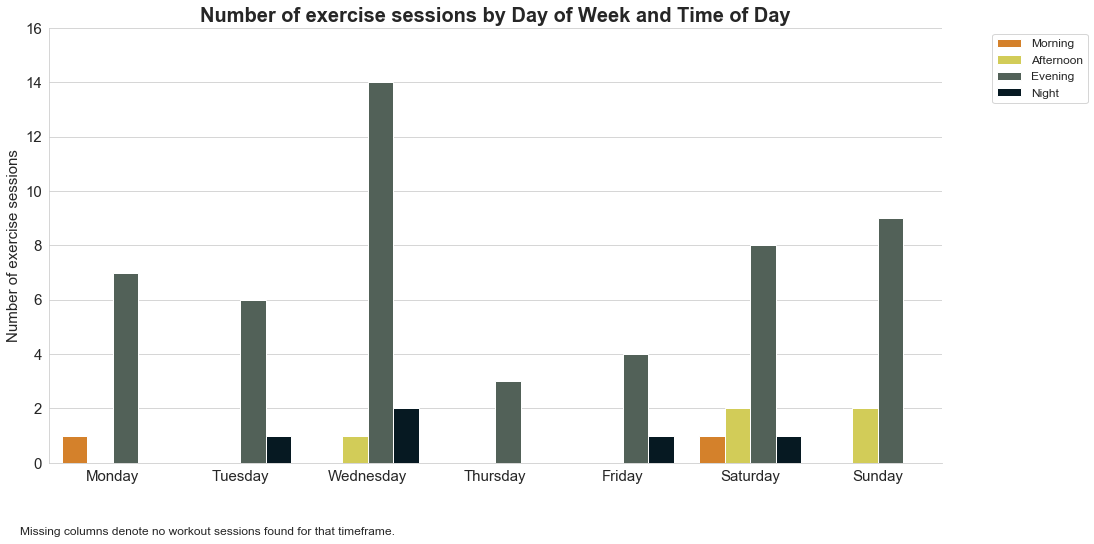

In [8]:
# Group number of sessions by day of week and time of day

session_num = fit_df.groupby(['dayofweek','timeofday'])['session_id'].nunique().reset_index()


# Plot the data

xorder = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16.0,8.0))
sns.barplot(x='dayofweek', y='session_id', order=xorder,
            hue='timeofday', hue_order=['Morning','Afternoon','Evening','Night'], 
            palette=['#F0810F','#E6DF44','#4F6457','#011A27'],
            data=session_num)

# Additional Styling

sns.despine()
plt.ylim(0,16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':12})
plt.title("Number of exercise sessions by Day of Week and Time of Day", fontsize=20, fontweight='bold')
plt.xlabel('')
plt.ylabel("Number of exercise sessions", fontsize=15)
plt.tick_params(bottom=False, labelsize=15)
plt.figtext(0.1, 0, 
            'Missing columns denote no workout sessions found for that timeframe.', fontsize=12)

---
A grouped, side-by-side bar chart helps to visualize and compare the number of exercise sessions done two layers of categorization - Day of week, and time of day.

---

---
<span style="color:#86AC41; font-size:20px "><i>4.2. Workout Distance</i></span>
    <div id='id-section4.2'></div>
    
---

In [9]:
# Group dataframe by each session. Note that for each session the distance captured is incremental
# so for every session the distance is calculated by taking the delta between max and min distance

distance = fit_df.groupby(['date','activity'])['distance'].agg(lambda x: x.max() - x.min()).reset_index()
distance.head()

,date,activity,distance
0,2019-07-08,Running,2617.46
1,2019-07-10,Running,849.94
2,2019-07-12,Running,7471.84
3,2019-07-14,Running,8471.55
4,2019-07-16,Running,1704.76


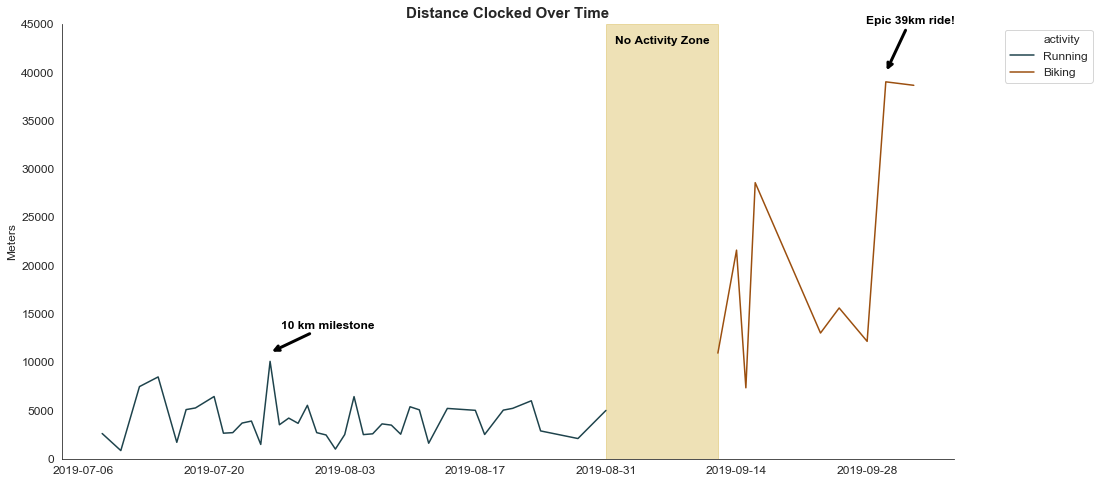

In [10]:
# Plot the data

sns.set_style("white")
fig, ax = plt.subplots(figsize=(16.0,8.0))
sns.lineplot(x='date', y='distance', hue='activity', data=distance, palette=['#1E434C','#9B4F0F']);

# Add annotations

plt.axvspan('2019-08-31', '2019-09-12', color='#C99E10', alpha=0.3)
plt.annotate('10 km milestone', xy=('2019-07-26', 11000), 
             xycoords='data', xytext=(0.35,0.3), textcoords='axes fraction', 
             fontsize=12, horizontalalignment='right', color='black', weight='bold',
             arrowprops=dict(arrowstyle='->, head_length=0.4, head_width=0.2', color='black', linewidth=3))
plt.annotate('Epic 39km ride!', xy=('2019-09-30', 40000), 
             xycoords='data', xytext=(1,1), textcoords='axes fraction', 
             fontsize=12, horizontalalignment='right', color='black', weight='bold',
             arrowprops=dict(arrowstyle='->, head_length=0.4, head_width=0.2', color='black', linewidth=3))
plt.text(x='2019-09-01', y=43000, s='No Activity Zone', 
         color='black', fontsize=12, weight='bold')


# Additional styling

sns.despine()
plt.ylim(0,45000)
plt.title("Distance Clocked Over Time", fontsize=15, fontweight='bold')
plt.xlabel('')
plt.ylabel("Meters", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':12})
plt.tick_params(bottom=False, labelsize=12)

---
Line graphs are by all means the most effective visualization type to illustrate the change in one variable over time. Seaborn has also enabled me to introduce a categorical (activity) variable into the visualization, thus providing not only information on distance clocked over time but also a comparison between activity types.

---

---
<span style="color:#86AC41; font-size:20px "><i>4.3. Workout Intensity</i></span>
    <div id='id-section4.3'></div>

---
According to [Healthline](https://www.healthline.com/health/fitness-exercise/fat-burning-heart-rate), heart rate can be used to measure the intensity of workout sessions, be it running or biking. 

When we work out in our fat-burning heart rate zone, the body taps into fat stores for energy instead of using basic sugars and carbohydrates, leading to fat loss. The fat-burning heart rate lies between 70 and 85 percent of a person's maximum heart rate. The maximum heart rate for someone at 40 years old is **180 BPM**.

---

In [11]:
# Group the dataframe by date and calculate the mean heart rate.

heart_rate = fit_df.groupby(['date','activity'])['heart_rate'].mean().reset_index()

# Calculate target heart rate

max_heart = 180
lower_heart = max_heart * .7
upper_heart = max_heart * .85

heart_rate.head()

,date,activity,heart_rate
0,2019-07-08,Running,118.337398
1,2019-07-10,Running,130.123596
2,2019-07-12,Running,117.687157
3,2019-07-14,Running,113.642361
4,2019-07-16,Running,118.858824


Text(0.1,0,'No heart rate data between 01 Sep - 11 Sep (inclusive), as well as 15 and 30 September.')

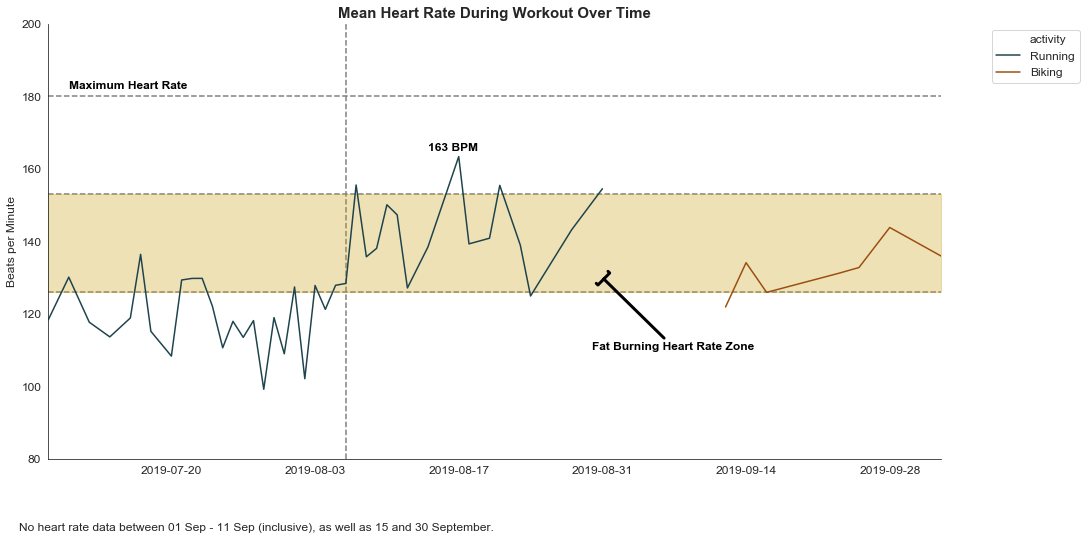

In [12]:
# Plot the data

sns.set_style("white")
fig, ax = plt.subplots(figsize=(16.0,8.0))
sns.lineplot(x='date', y='heart_rate', hue='activity', data=heart_rate, palette=['#1E434C','#9B4F0F']);

# Line and annotation

plt.axhline(lower_heart, color='grey', linestyle='--', zorder=0)
plt.axhline(upper_heart, color='grey', linestyle='--', zorder=0)
plt.axhline(max_heart, color='grey', linestyle='--', zorder=0)
plt.axvline('2019-08-06', color='grey', linestyle='--', zorder=0)
plt.fill_between(heart_rate['date'], lower_heart, upper_heart, alpha=.3, color='#C99E10')
plt.annotate('Fat Burning Heart Rate Zone', xy=(mdates.date2num(heart_rate.iloc[39]['date']), 130), 
             xycoords='data', xytext=(0.7,0.25), textcoords='axes fraction', 
             fontsize=12, horizontalalignment='center', color='black', weight='bold',
             arrowprops=dict(arrowstyle='-[, widthB=0.7', color='black', linewidth=3))
plt.text(x= mdates.date2num(heart_rate.iloc[1]['date']), y=182, 
         s='Maximum Heart Rate', color='black', fontsize=12, weight='bold')
plt.text(x= '2019-08-14', y=165, 
         s='{:.0f} BPM'.format(heart_rate.iloc[32]['heart_rate']), color='black', fontsize=12, weight='bold')



# Additional Styling

sns.despine()
plt.xlim(mdates.date2num(heart_rate.iloc[0]['date']),mdates.date2num(heart_rate.iloc[-1]['date']))
plt.ylim(80,200)
plt.title("Mean Heart Rate During Workout Over Time", fontsize=15, fontweight='bold')
plt.xlabel('')
plt.ylabel("Beats per Minute", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':12})
plt.tick_params(bottom=False, labelsize=12)
plt.figtext(0.1, 0, 
            'No heart rate data between 01 Sep - 11 Sep (inclusive), as well as 15 and 30 September.', fontsize=12)

---
<span style="color:#86AC41; font-size:20px "><i>4.4. Relationship between cadence and heart rate</i></span>
    <div id='id-section4.4'></div>

---
In running, [cadence](https://blog.wahoofitness.com/running-cadence-why-it-matters-and-how-to-improve-yours/) – also known as stride rate – is the number of steps a runner takes per minute (SPM). In cycling, [cadence](https://en.wikipedia.org/wiki/Cadence_(cycling)) (or pedalling rate) is the number of revolutions of the crank per minute; this is the rate at which a cyclist is pedalling/turning the pedals.

Cadence is an important metric for both running and biking alike. It is a measure of intensity as well as the efficiency of a runner/biker's effort. There are many factors driving cadence, but for this I will look at the most basic factor, i.e. heart rate and analyze whether there is any relationship between these two measurements. 

Scatterplots use a collection of points display values from two variables. By displaying a variable in each axis, scatterplots help to detect if a relationship or correlation between the two variables exists.

---

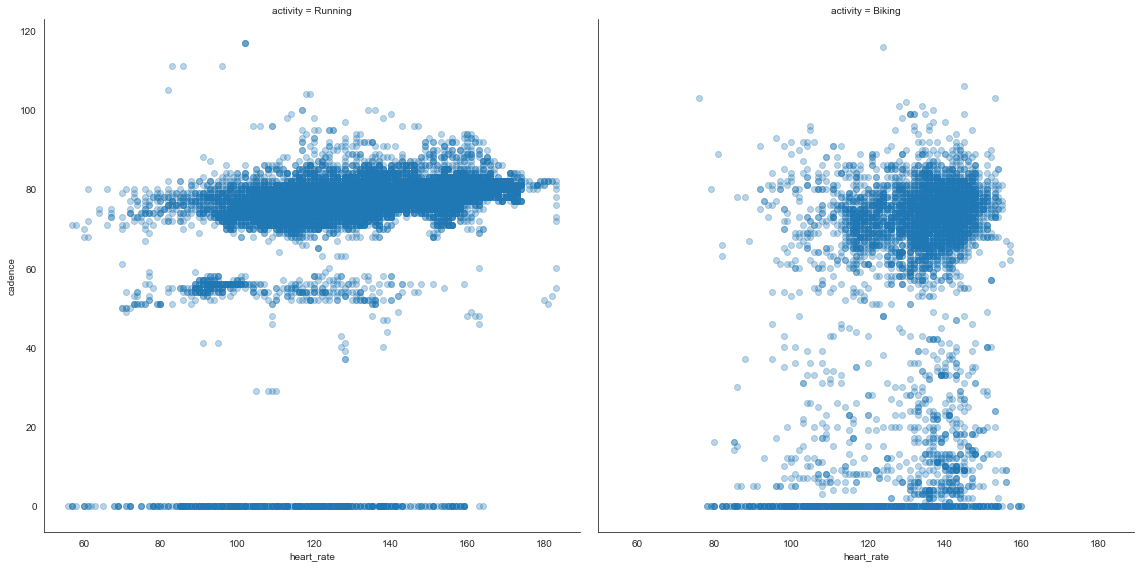

In [13]:
# Plot an exploratory cadence and heart rate data scatterplot

sns.FacetGrid(data=fit_df, col='activity', height=8, aspect=1).map(plt.scatter, 'heart_rate', 'cadence', alpha=.3)

---
On the left, the scatterplot for running looks promising. There is a straight line at the bottom for zero values in the cadence data, but beyond that we can see a majority of the data points form an upward sloping line. On the right hand side for biking however, there is no discernible pattern.

Recall that the strava data captured heart rate throughout the run, which means for each workout session, the heart rate would gradually increase as the workout went, whereas cadence changed very little throughout, meaning the user maintained a fairly constant running/biking pace.

Hence even though we have plotted all heart rate/cadence data onto a scatterplot, we'll also examine the relationship between cadence and heart rate using the average cadence and heart rate for each section.

---

In [14]:
# Group data frame to calculate avg. cadence and heart rate

cadence_hr = fit_df.groupby(['session_id','activity'])[['cadence','heart_rate']].mean().reset_index()
cadence_hr

,session_id,activity,cadence,heart_rate
0,2675855419,Running,74.406504,118.337398
1,2677658978,Running,77.191176,122.117647
2,2677658993,Running,81.777778,135.592593
3,2677659014,Running,79.517857,134.571429
4,2682705331,Running,74.135016,117.687157
...,...,...,...,...
59,2903861013,Biking,19.785953,NaN
60,2904156632,Biking,15.207906,132.779221
61,2912139332,Biking,72.507426,143.824257
62,2917827233,Biking,66.728424,NaN


---
Notice that the cadence for biking is rather strange for session id 2903861013 and 2904156632 - they are both 
unrealistically low. We'll take a closer look at the strava data file to see what's going on.

---

In [15]:
outliers = fit_df[(fit_df['session_id'] == '2903861013') | (fit_df['session_id'] == '2904156632')]
outliers['cadence'].value_counts()

0.0     298
4.0      39
9.0      35
6.0      35
5.0      32
       ... 
65.0      1
44.0      1
88.0      1
89.0      1
53.0      1
Name: cadence, Length: 75, dtype: int64

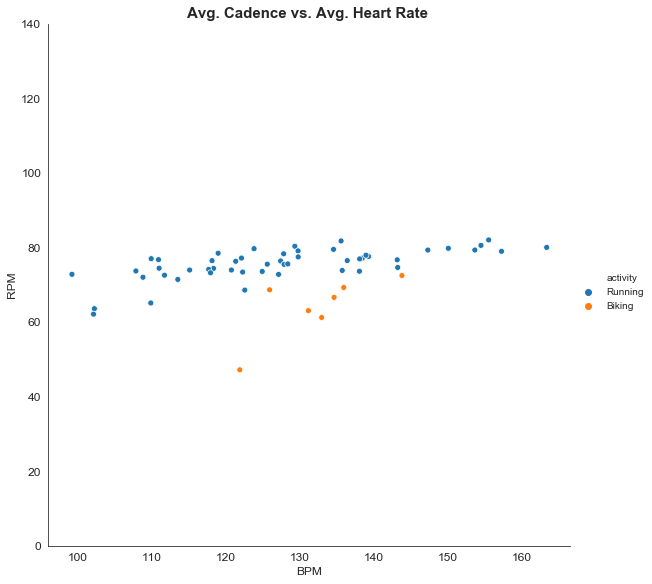

In [16]:
# Remove two incorrectly captured sessions

cadence_hr = cadence_hr[(cadence_hr['session_id'] != '2903861013') & (cadence_hr['session_id'] != '2904156632')]


# Re-plot the data

sns.set_style("white")
sns.relplot(x='heart_rate', y='cadence', hue='activity', data=cadence_hr, 
            height=8, aspect=1)


# Additional Styling

sns.despine()
plt.ylim(0,140)
plt.title("Avg. Cadence vs. Avg. Heart Rate ", fontsize=15, fontweight='bold')
plt.xlabel("BPM", fontsize=12)
plt.ylabel("RPM", fontsize=12)
plt.tick_params(bottom=False, labelsize=12)

---
The plot looks consistent with the previous one - there's a clear upward sloping line indicating a positive linear relationship between the average cadence and average heart rate for each running session. 

Lastly, we'll take the same data and use regplot, which plots the same data, but also adds a linear regression model fit.

---

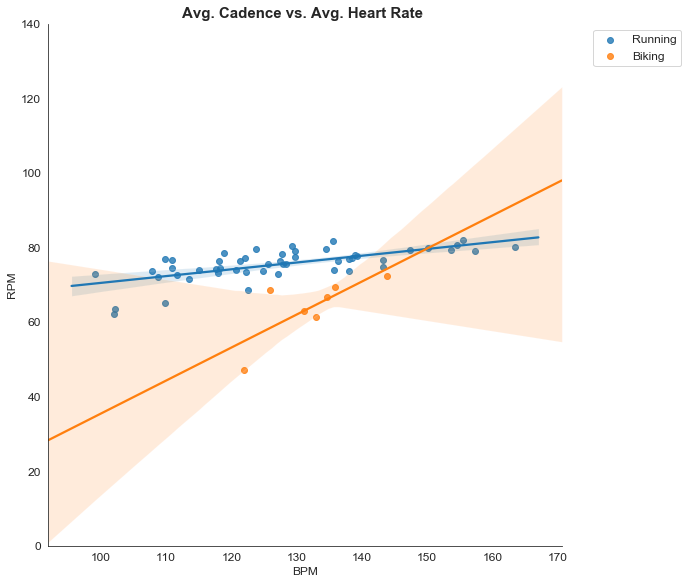

In [17]:
# Use regplot instead to add regression line

sns.set_style("white")
sns.lmplot(x='heart_rate', y='cadence', hue='activity', data=cadence_hr,
          height=8, aspect=1, legend=False)

# Additional Styling

sns.despine()
plt.ylim(0,140)
plt.title("Avg. Cadence vs. Avg. Heart Rate ", fontsize=15, fontweight='bold')
plt.xlabel("BPM", fontsize=12)
plt.ylabel("RPM", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':12})
plt.tick_params(bottom=False, labelsize=12)

---

At first glance, the best fit line for running fits the data points quite well - most points fall directly or very near the line. For biking, this is less so the case, but once again bear in mind that there aren't many data points available for biking after removing the sessions with no heart rate data captured.

---

---
<span style="color:#86AC41; font-size:20px "><i>4.5. Geographical View of Running/Biking Routes</i></span>
    <div id='id-section4.5'></div>

--- 
There are many Python libraries available that allow users to plot geospatial data. I chose Folium in particular for the Folium module provides a way to feed data in Python into a Leaflet.js map. Leaflet maps are interactive, attractive, and can be directly inserted into webpages. Folium provides many options to customize maps, making it an ideal candidate for this exercise.

---

In [18]:
# We need to convert the lat/long data in the strava dataset into the traditional decimal format
# This can be done by multiplying by 180 degrees then dividing by 2 to the power of 31

fit_df['position_lat_degree'] = fit_df['position_lat'] * (180 / 2**31)
fit_df['position_long_degree'] = fit_df['position_long'] * (180 / 2**31)

# Let's take a look at the dataframe again
fit_df.head()

,session_id,altitude,cadence,distance,speed,heart_rate,position_lat,position_long,timestamp,avg_speed,activity,date,month,dayofweek,timeofday,position_lat_degree,position_long_degree
0,2675855419,NaN,0.0,0.00,0.000,68.0,NaN,NaN,2019-07-08 21:04:03,2.088154,Running,2019-07-08,7,Monday,Evening,NaN,NaN
1,2675855419,NaN,0.0,0.00,0.000,68.0,NaN,NaN,2019-07-08 21:04:04,2.088154,Running,2019-07-08,7,Monday,Evening,NaN,NaN
2,2675855419,NaN,54.0,1.32,1.316,71.0,NaN,NaN,2019-07-08 21:04:07,2.088154,Running,2019-07-08,7,Monday,Evening,NaN,NaN
3,2675855419,3747.0,77.0,12.19,1.866,77.0,504432050.0,-999063637.0,2019-07-08 21:04:14,2.088154,Running,2019-07-08,7,Monday,Evening,42.281006,-83.740547
4,2675855419,3798.0,77.0,14.08,1.894,80.0,504432492.0,-999064534.0,2019-07-08 21:04:15,2.088154,Running,2019-07-08,7,Monday,Evening,42.281043,-83.740622


In [19]:
# To provide user with the liberty to visualize the running/biking route for any date of choice, I will wrap 
# the visualization code into a function

def route_map(day, month, year):
    # Filter dataframe using the date specified. Get the lat/long degree columns and convert values into a list
    date_choice = fit_df[fit_df['date'] == pd.Timestamp(year,month,day)]
    locations = date_choice[['position_lat_degree','position_long_degree']]
    locations = locations.dropna()
    locations_lst = locations.values.tolist()
    
    # Create base map
    strava_map = folium.Map(location=[locations['position_lat_degree'].mean(),locations['position_long_degree'].mean()],
                            tiles='Stamen Terrain',
                            zoom_start=14)

    # Add start and stop markers, as well as tooltip
    tooltip_start = "Start"
    tooltip_stop = "End"
    folium.Marker(locations_lst[0], 
                  icon=folium.Icon(color='green', icon='play'),
                  tooltip=tooltip_start).add_to(strava_map)
    folium.Marker(locations_lst[-1], 
                  icon=folium.Icon(color='red', icon='stop'), 
                  tooltip=tooltip_stop).add_to(strava_map)

    # Plot running route
    folium.PolyLine(locations_lst, color="#C05805", weight=4, opacity=.8).add_to(strava_map)
    
    return strava_map



In [20]:
# Let's try to view the route on 26 July
route_map(26,7,2019)

In [21]:
# That looks to be a pretty scenic run along the Huron River, covering both Gallup and Fuller Park.
# Now let's visualize a biking session. 
route_map(30,9,2019)

[^Back to top](#id-section1)